In [83]:
'''
 Load data. Input files defined in yaml files (destest_bpz.yaml, destest_metacal.yaml,destest_gold.yaml)
 It requires destest : 
 https://github.com/des-science/destest
 
 catalogs (to be specified in the yaml files):
 
 Latest version '/global/cscratch1/sd/troxel/cats_des_y3/Y3_mastercat_v2_6_20_18.h5'
 Latest subsampled version (for quick tests): '/global/cscratch1/sd/troxel/cats_des_y3/Y3_mastercat_v2_6_20_18_subsampled.h5'
 
 I didn't manage to run the destest Calibrator. This means that if you directly load R1 and R2 from the catalog,
 they are only the respones of the sample and neglect the response of the selection (which is usually few %).
 The solution I got was to load the columns without selection (uncut=True)
 and apply the response and selection by myself.
'''



import sys
#sys.path.insert(0, '/global/homes/m/mgatti/Mass_Mapping/systematic_checks/')
from routines import *
import numpy as np

import yaml
param_file = './destest_metacal.yaml'


# ******************************************************************
#                              INPUT
# ******************************************************************
nside = 1024  


matercat_file = "/project/projectdirs/des/www/y3_cats/Y3_mastercat_7_24_19.h5"
pathz = '/global/homes/j/jderose/cscratch/BCC/Chinchilla/Herd/Chinchilla-3/y3_full/nofz/nz_source_zbin.h5'

zbins = 4

# output folders ***************
fold1= '/global/cscratch1/sd/mgatti/Cosmic_shear/output_ABE/'  
name_folder_x = '/global/cscratch1/sd/mgatti/Cosmic_shear/output_ABE/new_binning/'

if not os.path.exists(fold1):
    os.mkdir(fold1)
if not os.path.exists(name_folder_x):
    os.mkdir(name_folder_x)



# load catalog

In [97]:
import h5py
import numpy as np
f = h5py.File("//project/projectdirs/des/www/y3_cats/Y3_mastercat_7_24_19.h5","r")

cat =  f['catalog/metacal/unsheared']

# read jackknife info 
dist =  np.array(f['regions']['centers']['dist'])
ra_hpx = np.array(f['regions']['centers']['ra'])
dec_hpx = np.array(f['regions']['centers']['dec'])


nrows = len(np.array( cat['ra'] ))
formats = []
keys = ['R11', 'R12', 'R21', 'R22', u'T', u'e_1',u'e_2','ra','dec']# u'coadd_object_id', u'covmat_0_1', u'covmat_1_1', u'covmat_2_2', u'dec', u'e_1', u'e_2', u'flags', u'flux_err_i', u'flux_err_r', u'flux_err_z', u'flux_i', u'flux_r', u'flux_z', u'mask_frac', u'mcal_psf_T', u'mcal_psf_e1', u'mcal_psf_e2', u'nimage_tot_i', u'nimage_tot_r', u'nimage_tot_z', u'nimage_use_i', u'nimage_use_r', u'nimage_use_z', u'psf_T', u'psf_e1', u'psf_e2', u'ra', u'size_ratio', u'snr']
for key in keys:
    if key == 'ccd' or key == 'tiling':
        formats.append('i2')
    elif key == 'exp' or 'flag' in key:
        formats.append('i4')
    elif key == 'band':
        formats.append('a1')
    else:
        formats.append('f4')
        

data = np.recarray(shape=(nrows,), formats=formats, names=keys)
for key in keys:  data[key] = np.array(cat[key])    
print('made recarray')
select = np.array(f['index/select'])
select_1p = np.array(f['index/select_1p'])
select_1m = np.array(f['index/select_1m'])
select_2p = np.array(f['index/select_2p'])
select_2m = np.array(f['index/select_2m']) 
zmean = np.array(f['catalog']['bpz']['unsheared']['zmean_sof'])
n = h5py.File(pathz, 'r')
zbin_array = np.array(n['nofz/zbin'])



# computation of response
response = dict()
for zbin in range(zbins):
    ind = np.where( zbin_array==zbin )[0]
    ind_1p = np.where(np.array(n['nofz/zbin_1p'])==zbin)
    ind_1m = np.where(np.array(n['nofz/zbin_1m'])==zbin)
    ind_2p = np.where(np.array(n['nofz/zbin_2p'])==zbin)
    ind_2m = np.where(np.array(n['nofz/zbin_2m'])==zbin)
    dgamma=0.01*2
    R11s = (data['e_1'][select_1p][ind_1p].mean() - data['e_1'][select_1m][ind_1m].mean() )/dgamma
    R22s = (data['e_2'][select_2p][ind_2p].mean() - data['e_2'][select_2m][ind_2m].mean() )/dgamma
    R11s +np.mean(data['R11'][select][ind])
    response[zbin]= [R11s +np.mean(data['R11'][select][ind]),R22s +np.mean(data['R22'][select][ind])]


    save_obj(name_folder_x+"/response",response)

# jackknife preparation
hpix = np.array(f['regions']['catalog']['gold'][u'region'])

for i in range(zbins):
    n_jck = len(ra_hpx)
    name_foder =name_folder_x+'_{0}/'.format(i)

    if not os.path.exists(name_foder):    
        os.mkdir(name_foder)

    label_dist = name_foder +'distance_PARTIAL_{0}_{1}'.format(0,n_jck)
    save_obj(label_dist,dist)
    
centers = np.vstack([(np.array(f['regions']['centers']['ra']),np.array(f['regions']['centers']['dec']))]).T
f.close()

# jackknife assignment to stars
bbb = np.vstack([np.array(ras).T,
                             np.array(decs).T]).T
from scipy import spatial
from astropy.table import Table
_, hpix_s =  (spatial.cKDTree(centers)).query(bbb)

made recarray


# Load stars

In [5]:
%matplotlib inline
# Load reserved stars and make grids
path_qq = "/global/homes/m/mjarvis/desdata/users/mjarvis/y3a1-v29/psf_y3a1-v29.fits"
output = "/global/cscratch1/sd/mgatti/Cosmic_shear/shape_systematics/"



prova =  field_methods()
fact = 0.05703422

mute11 = pf.open(path_qq)
dd_qq = mute11[1].data

ras  = mute11[1].data['ra']
decs  = mute11[1].data['dec']
p1  = mute11[1].data['piff_e1']
p2  = mute11[1].data['piff_e2']
q1  = mute11[1].data['obs_e1']-mute11[1].data['piff_e1']
q2  = mute11[1].data['obs_e2']-mute11[1].data['piff_e2']
w1  = mute11[1].data['piff_e1']*((mute11[1].data['obs_T ']-mute11[1].data['piff_T'])/mute11[1].data['obs_T'])
w2  = mute11[1].data['piff_e2']*((mute11[1].data['obs_T ']-mute11[1].data['piff_T'])/mute11[1].data['obs_T'])


bb = mute11[1].data['band'] 
mag = mute11[1].data['mag'] 
maks=((bb =='i') | (bb =='r') | (bb =='z')) & (mag<20)
print "done"


done


# prepare runs

In [145]:
Nbins = 20

min_theta = 0.1/60.
max_theta = 250./60.
number_of_cores = 64
bin_slope = 0.03


rewrite = False
runs_path = dict()
count = 0

conf = {'nbins': Nbins,
            'min_sep': min_theta,
            'max_sep': max_theta,
            'sep_units': 'degrees',
            'bin_slop': bin_slope,
            'nodes': number_of_cores  # parameter for treecorr
            }

ra = (sample_dict['ra'])
dec = (sample_dict['dec'])

runs_path=dict()
count =0
for ii in range(zbins):
   
    name_foder =name_folder_x+'_{0}/'.format(ii)
    outp_fold = name_foder+'/pairs/'
    name_output  = name_foder+'/y3_sm2_'
    
    if not os.path.exists(name_foder):    
        os.mkdir(name_foder)

    ind = np.where( zbin_array==ii )[0]
    
    print "1"


    mute_dict = dict()
    mute_dict['conf'] = conf
    mute_dict['label_dist'] = label_dist
    mute_dict['ra_1'] = data['ra'][select][ind]
    mute_dict['dec_1'] =  data['dec'][select][ind]
    mute_dict['ra_2'] = ras[maks]
    mute_dict['dec_2'] = decs[maks]
    mute_dict['hpix1'] = hpix[select][ind]
    mute_dict['hpix2'] = hpix_s[maks]
    mute_dict['w1'] = np.ones(len(hpix[select][ind]))
    mute_dict['w2'] = np.ones(len( w2[maks]))
    mute_dict['g1_1'] = data['e_1'][select][ind]
    mute_dict['g2_1'] = data['e_2'][select][ind]
    mute_dict['g1_2'] = w1[maks]
    mute_dict['g2_2'] = w2[maks]
    mute_dict['centers']=centers
    mute_dict['n_jck']= n_jck
    mute_dict['path_pkl'] = name_output+'_w_full2'
    mute_dict['outp_fold'] = outp_fold
    mute_dict['label'] ='{0}_w_l2'.format("full")

    if not os.path.exists(name_output):
        os.mkdir(name_output)
    path_run  = name_output+"_w_full2_"
    runs_path[count]=path_run
    save_obj(path_run,mute_dict)
    count+=1








    mute_dict = dict()
    mute_dict['conf'] = conf
    mute_dict['label_dist'] = label_dist
    mute_dict['ra_1'] = data['ra'][select][ind]
    mute_dict['dec_1'] =  data['dec'][select][ind]
    mute_dict['ra_2'] = ras[maks]
    mute_dict['dec_2'] = decs[maks]
    mute_dict['hpix1'] = hpix[select][ind]
    mute_dict['hpix2'] = hpix_s[maks]
    mute_dict['w1'] = np.ones(len(hpix[select][ind]))
    mute_dict['w2'] = np.ones(len( w2[maks]))
    mute_dict['g1_1'] = data['e_1'][select][ind]
    mute_dict['g2_1'] = data['e_2'][select][ind]
    mute_dict['g1_2'] = q1[maks]
    mute_dict['g2_2'] = q2[maks]
    mute_dict['centers']=centers
    mute_dict['n_jck']= n_jck
    mute_dict['path_pkl'] = name_output+'_q_full2'
    mute_dict['outp_fold'] = outp_fold
    mute_dict['label'] ='{0}_q_l2'.format("full")

    if not os.path.exists(name_output):
        os.mkdir(name_output)
    path_run  = name_output+"_q_full2_"
    runs_path[count]=path_run
    save_obj(path_run,mute_dict)
    count+=1



    mute_dict = dict()
    mute_dict['conf'] = conf

    mute_dict['label_dist'] = label_dist
    mute_dict['ra_1'] = data['ra'][select][ind]
    mute_dict['dec_1'] =  data['dec'][select][ind]
    mute_dict['ra_2'] = ras[maks]
    mute_dict['dec_2'] = decs[maks]
    mute_dict['hpix1'] = hpix[select][ind]
    mute_dict['hpix2'] = hpix_s[maks]
    mute_dict['w1'] = np.ones(len(hpix[select][ind]))
    mute_dict['w2'] = np.ones(len( w2[maks]))
    mute_dict['g1_1'] = data['e_1'][select][ind]
    mute_dict['g2_1'] = data['e_2'][select][ind]
    mute_dict['g1_2'] = p1[maks]
    mute_dict['g2_2'] = p2[maks]
    mute_dict['centers']=centers
    mute_dict['n_jck']= n_jck
    mute_dict['path_pkl'] = name_output+'_p_full2'
    mute_dict['outp_fold'] = outp_fold
    mute_dict['label'] ='{0}_p_l2'.format("full")

    if not os.path.exists(name_output):
        os.mkdir(name_output)
    path_run  = name_output+"_p_full2_"
    runs_path[count]=path_run
    save_obj(path_run,mute_dict)
    count+=1 
            
print ('done')
save_obj("runs_path_ABE",runs_path)


1
1
1
1
done


# collate output          
            

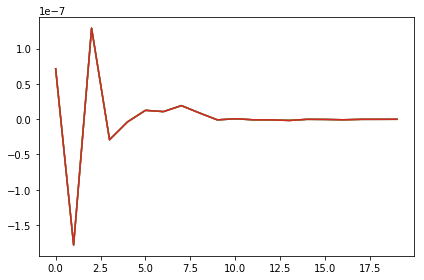

In [154]:
# quick plots *******

rrs=["w"]#,"q","w"]

xx = zbins

for hh in range(zbins):
    ataus = dict()
    for rr in rrs:
        tpv = []
        tmv = []
        tp = []
        tm = []

        path = name_folder_x+"_{0}/y3_sm2__{1}_full2_noweight".format(hh,rr)
        muteaa = load_obj(path)
        tpv.append(muteaa['high']["xip"])
        tmv.append(muteaa['high']["xim"])
        tp.append(muteaa['high']["corr_jckp"].T)
        tm.append(muteaa['high']["corr_jckm"].T)
        ataus[rr+"_pv"]=tpv
        print 
        plt.plot(muteaa['high']["xip"])
        #plt.show()

In [126]:
xx = zbins
rrs=["p","q","w"]
r = load_obj(name_folder_x+"/response")

R = [0.5*(r[0][0]+r[0][1]),0.5*(r[1][0]+r[1][1]),0.5*(r[2][0]+r[2][1]),0.5*(r[3][0]+r[3][1])]



for hh in range(zbins):
    ataus = dict()
    for rr in rrs:
        tpv = []
        tmv = []
        tp = []
        tm = []

        name_folder_x+"_{0}/y3_sm2__{1}_full2_noweight".format(hh,rr)
        muteaa = load_obj(path)
        tpv.append(muteaa['high']["xip"]/R[hh])
        tmv.append(muteaa['high']["xim"]/R[hh])
        tp.append(muteaa['high']["corr_jckp"].T/R[hh])
        tm.append(muteaa['high']["corr_jckm"].T/R[hh])
        ataus[rr+"_pv"]=tpv
        ataus[rr+"_mv"]=tmv
        ataus[rr+"_p"]=tp
        ataus[rr+"_m"]=tm
    for key in ataus.keys():
        try:
            ataus[key] = np.array(ataus[key]).reshape(20*xx,1000)
            woa = covariance_jck(ataus[key],1000,"jackknife")
            #taus[key+"_cov"]=woa["cov"]
        except:
            ataus[key] = np.array(ataus[key]).reshape(20*xx)
    entries=['p_p','p_m','q_p','q_m','w_p','w_m']
    t = []
    for entr in entries:
        t.append(np.array(ataus[entr]).reshape(20*xx,1000))
    t = np.array(t).reshape(6*np.array(t).shape[1],1000)
    woa = covariance_jck(t,1000,"jackknife")
    
    
    from astropy.io import fits
    tau0marr = ataus["p_mv"]; tau2marr = ataus["q_mv"];  tau5marr = ataus["w_mv"];
    tau0parr = ataus["p_pv"]; tau2parr = ataus["q_pv"];  tau5parr = ataus["w_pv"];
    taus = [tau0parr, tau0marr, tau2parr, tau2marr, tau5parr, tau5marr]
    taus_names = ['TAU0P', 'TAU0M','TAU2P','TAU2M', 'TAU5P', 'TAU5M']
    ##Format of the fit file output


            
    names=['BIN1', 'BIN2','ANGBIN', 'VALUE', 'ANG']
    forms = ['i4', 'i4', 'i4',  'f4',  'f4']
    dtype = dict(names = names, formats=forms)
    nrows = len(tau0marr)
    outdata = np.recarray((nrows, ), dtype=dtype)
    covmat = woa["cov"]
    hdu = fits.PrimaryHDU()
    hdul = fits.HDUList([hdu])
    covmathdu = fits.ImageHDU(covmat, name='COVMAT')
    hdul.insert(1, covmathdu)
    zbin=hh+1
    bin1array = np.array([ zbin]*nrows)
    bin2array = np.array([ -999]*nrows)
    angbinarray = np.arange(nrows)


    angarray = np.array([muteaa['high']["theta"]*60.]*xx).reshape(xx*20)
    for j, nam in enumerate(taus_names):
       outdata = np.recarray((nrows, ), dtype=dtype)
       array_list = [bin1array, bin2array, angbinarray,np.array(taus[j]),  angarray ]
       for array, name in zip(array_list, names): outdata[name] = array

       corrhdu = fits.BinTableHDU(outdata, name=nam)
       hdul.insert(j+2, corrhdu)
    hdul[1].header['COVDATA'] = True
    hdul[1].header['EXTNAME'] =  'COVMAT'
    hdul[1].header['NAME_0'] =  'TAU0'
    hdul[1].header['STRT_0'] =  0
    hdul[1].header['LEN_0'] = nrows
    hdul[1].header['NAME_1'] =  'TAU2'
    hdul[1].header['STRT_1'] =  nrows
    hdul[1].header['LEN_1'] = nrows
    hdul[1].header['NAME_2'] =  'TAU5'
    hdul[1].header['STRT_2'] =  2*nrows
    hdul[1].header['LEN_2'] = nrows
    hdul[2].header['QUANT1'] = 'GeR'; hdul[3].header['QUANT1'] = 'GeR'
    hdul[2].header['QUANT2'] = 'PeR'; hdul[3].header['QUANT2'] = 'PeR'
    hdul[4].header['QUANT1'] = 'GeR'; hdul[5].header['QUANT1'] = 'GeR'
    hdul[4].header['QUANT2'] = 'PqR'; hdul[5].header['QUANT2'] = 'PqR'
    hdul[6].header['QUANT1'] = 'GeR'; hdul[7].header['QUANT1'] = 'GeR'
    hdul[6].header['QUANT2'] = 'PwR'; hdul[7].header['QUANT2'] = 'PwR'

    if os.path.exists("/global/cscratch1/sd/mgatti/Cosmic_shear/" + 'tau_{0}.fits'.format(hh+1)):
        os.remove("/global/cscratch1/sd/mgatti/Cosmic_shear/"+ 'tau_{0}.fits'.format(hh+1))
    outname = os.path.join("/global/cscratch1/sd/mgatti/Cosmic_shear/", 'tau_{0}.fits'.format(hh+1))
    hdul.writeto(outname, overwrite=True)

[(1, -999,  0,   4.57650640e-06,    1.14801753)
 (1, -999,  1,   6.68353277e-06,    1.5130229 )
 (1, -999,  2,   7.28525356e-06,    1.99407959)
 (1, -999,  3,   6.05430932e-06,    2.62808561)
 (1, -999,  4,   6.04366642e-06,    3.46367002)
 (1, -999,  5,   6.37104813e-06,    4.56492329)
 (1, -999,  6,   6.00479734e-06,    6.01631403)
 (1, -999,  7,   5.83447490e-06,    7.92916584)
 (1, -999,  8,   5.63867025e-06,   10.45019722)
 (1, -999,  9,   5.54344388e-06,   13.7727766 )
 (1, -999, 10,   5.36145990e-06,   18.15175056)
 (1, -999, 11,   4.87287980e-06,   23.92299271)
 (1, -999, 12,   4.77928870e-06,   31.52916718)
 (1, -999, 13,   4.57443230e-06,   41.55368042)
 (1, -999, 14,   4.35052698e-06,   54.76543045)
 (1, -999, 15,   3.92810534e-06,   72.17778015)
 (1, -999, 16,   3.43586998e-06,   95.12628174)
 (1, -999, 17,   3.38461246e-06,  125.37112427)
 (1, -999, 18,   3.60339573e-06,  165.23213196)
 (1, -999, 19,   3.55894758e-06,  217.76672363)]
0
[(1, -999,  0,  -2.17041202e-06,    1

In [127]:
mut = pf.open("/global/cscratch1/sd/mgatti/Cosmic_shear/"+ 'tau_{0}.fits'.format(hh+1))

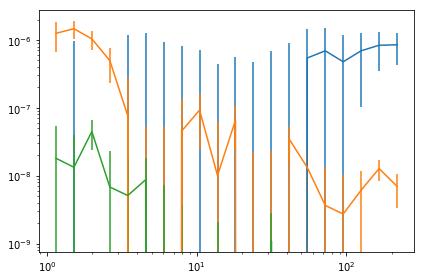

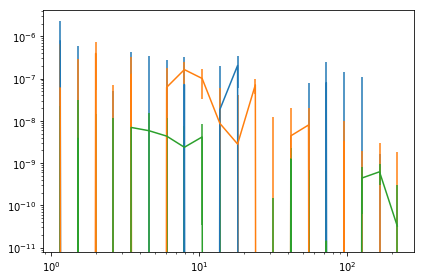

In [128]:
err = np.sqrt(mut[1].data.diagonal())

plt.errorbar(mut[2].data['ANG'],mut[2].data['VALUE'],err[:20])
plt.errorbar(mut[4].data['ANG'],mut[4].data['VALUE'],err[40:60])
plt.errorbar(mut[6].data['ANG'],mut[6].data['VALUE'],err[80:100])
plt.xscale('log')
plt.yscale('log')
plt.show()


plt.errorbar(mut[2].data['ANG'],mut[3].data['VALUE'],err[20:40])
plt.errorbar(mut[4].data['ANG'],mut[5].data['VALUE'],err[60:80])
plt.errorbar(mut[6].data['ANG'],mut[7].data['VALUE'],err[100:120])
plt.xscale('log')
plt.yscale('log')
plt.show()